# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


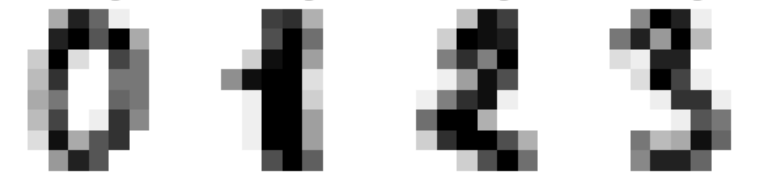



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

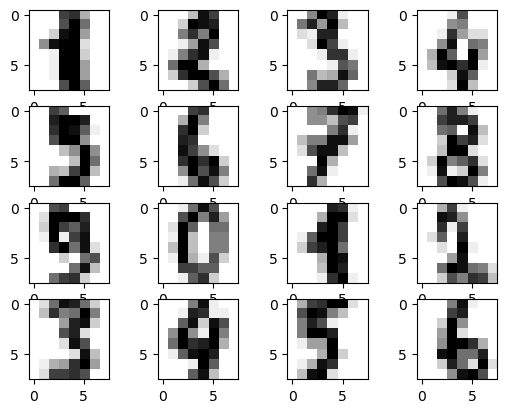

In [115]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [116]:
# Cargo los dígitos
#X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target

# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y==0) | (y == 1)]

X_bin = X[bin_indices,:,:]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print("Total de 0s para clasificación binaria: " + str(y_bin_test.shape[0] - y_bin_test.sum()))


Total de datos para clasificación entre 10 dígitos: 1797
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

In [117]:
X_bin[1,:,:] #veamos como se ve la imagen

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

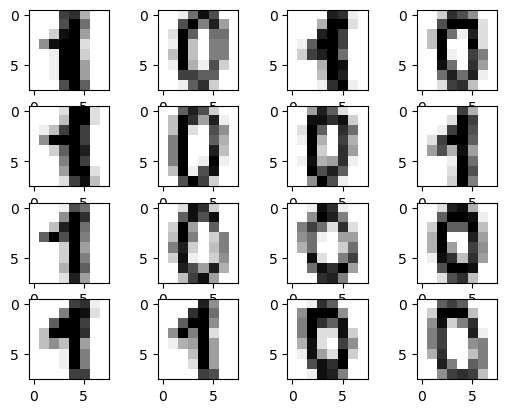

In [118]:
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(X_bin[i,:,:], cmap=plt.get_cmap('gray_r'))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

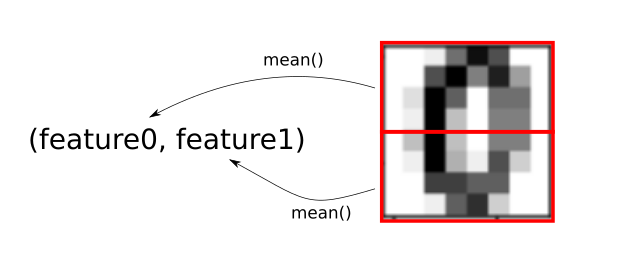

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

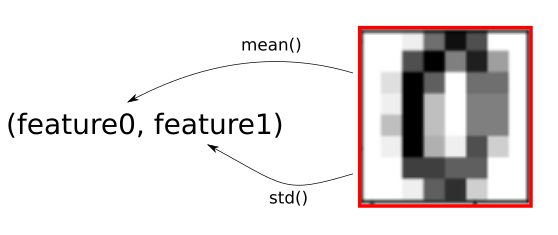


In [119]:
#prueba
(X_bin[1,:,:])[0:4,:]

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.]])

In [120]:
def extract_features_mean_std(x):
  x_out = np.zeros(shape=(1,2)) #vector de dos valores
  x_out[0,0] = np.mean(x)
  x_out[0,1] = np.std(x)
  return x_out

def extract_features_mean_top_bottom(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = np.mean(x[0:4,:])
  x_out[0,1] = np.mean(x[4:8,:])
  return x_out

def preprocess_features_mean_std(X):
  X_pp = np.zeros(shape=(X.shape[0], 2)) #cantidad de imagenes que tengo x 2 (para guardar los dos features que extraje)

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_std(X[i,:,:])

  return X_pp
  
def preprocess_features_mean_top_bottom(X):
  X_pp = np.zeros(shape=(X.shape[0], 2)) #cantidad de imagenes que tengo x 2 (para guardar los dos features que extraje)

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_top_bottom(X[i,:,:])

  return X_pp

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

In [121]:
from sklearn.linear_model import Perceptron

# Definimos un perceptrón
clasificador_1 = Perceptron()
clasificador_2 = Perceptron()

#Transformamos las features de los datos para el problema binario
X_bin_train_features_e1 = preprocess_features_mean_std(X_bin_train)
X_bin_test_features_e1 = preprocess_features_mean_std(X_bin_test)

X_bin_train_features_e2 = preprocess_features_mean_top_bottom(X_bin_train)
X_bin_test_features_e2 = preprocess_features_mean_top_bottom(X_bin_test)

# Entrenamos el clasificador
clasificador_1 = clasificador_1.fit(X_bin_train_features_e1, y_bin_train) #entreno al clasificador con los datos de entrenamiento y las features que extraje
clasificador_2 = clasificador_2.fit(X_bin_train_features_e2, y_bin_train)

# Imprimir la accuracy en los datos de test.
print("mean_std Accuracy en test: " + str(clasificador_1.score( X_bin_test_features_e1, y_bin_test ))) #evaluo el clasificador con los datos de test y las features que extraje
print("mean_top_bottom  Accuracy en test: " + str(clasificador_2.score( X_bin_test_features_e2, y_bin_test )))

# Imprimir las predicciones realizadas para los datos de test
print("mean_std Predictions: " + str(clasificador_1.predict( X_bin_test_features_e1))) #evaluo el clasificador con los datos de test y las features que extraje
print("mean_top_bottom Predictions: " + str(clasificador_2.predict( X_bin_test_features_e2))) 

mean_std Accuracy en test: 0.8319327731092437
mean_top_bottom  Accuracy en test: 0.5378151260504201
mean_std Predictions: [1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 1 1 0 0 1 0 0]
mean_top_bottom Predictions: [0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1
 0 1 1 1 0 1 1 1]


# Visualizando las features

Para entender el grado de discriminabilidad que presentan nuestras features, vamos a visualizarlas. Para hacerlo, colorear los items de cada clase con un color diferente.

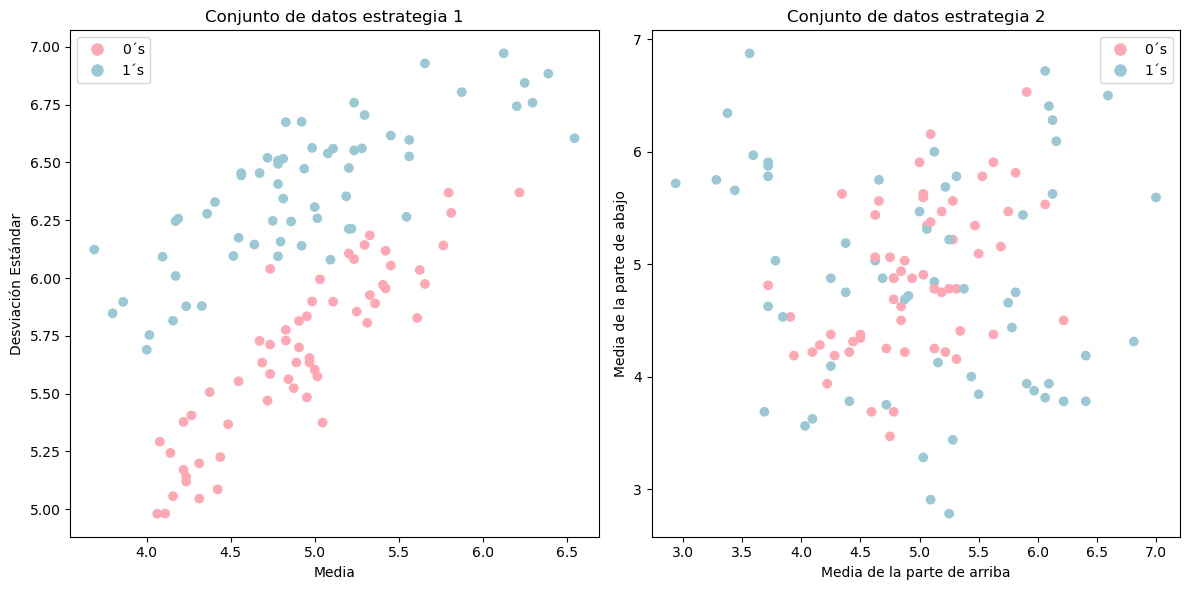

In [122]:
import matplotlib.pyplot as plt

color_rosa_pastel = '#FFA8B3'
color_celeste_pastel = '#9AC8D5'

color_map = {0: color_rosa_pastel, 1: color_celeste_pastel}  
colores = [color_map[y] for y in y_bin_test]

# Crear una figura con dos subplots (uno encima del otro)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))  # Ajusta el tamaño de la figura según sea necesario

# Gráfico 1: Scatter plot para el primer conjunto de datos
axes[0].scatter(X_bin_test_features_e1[:, 0], X_bin_test_features_e1[:, 1], c=colores)
axes[0].set_xlabel('Media')
axes[0].set_ylabel('Desviación Estándar')
axes[0].set_title('Conjunto de datos estrategia 1')

# Gráfico 2: Scatter plot para el segundo conjunto de datos
axes[1].scatter(X_bin_test_features_e2[:, 0], X_bin_test_features_e2[:, 1], c=colores)
axes[1].set_xlabel('Media de la parte de arriba')
axes[1].set_ylabel('Media de la parte de abajo')
axes[1].set_title('Conjunto de datos estrategia 2')

# Ajustar automáticamente el diseño para evitar solapamientos
plt.tight_layout()

#Agregamos la leyend
axes[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_rosa_pastel, markersize=10, label='0´s'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_celeste_pastel, markersize=10, label='1´s')])
axes[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_rosa_pastel, markersize=10, label='0´s'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_celeste_pastel, markersize=10, label='1´s')])

# Mostrar la figura combinada
plt.show()


# Complicando las cosas: 


Ahora volvemos al caso de 10 dígitos y probamos la misma estrategia que estábamos usando anteriormente.

In [123]:
# Utilizamos unicamente la estrategia de usar las features de mean y standard deviation, pues fue claramente el de mejor accuracy de las dos estrategias vistas

# Definimos un pereceptrón
clasificador10 = Perceptron()

X_train_features = preprocess_features_mean_std(X_train)
X_test_features = preprocess_features_mean_std(X_test)

clasificador10 = clasificador10.fit(X_train_features, y_train)

# Imprimir la accuracy en los datos de test.
print("Accuracy en test: " + str(clasificador10.score(X_test_features, y_test)))

# Imprimir las predicciones realizadas para los datos de test

print("Predictions: " + str(clasificador10.predict(X_test_features)))
print("Reales: " + str(y_test))

Accuracy en test: 0.13973063973063973
Predictions: [5 8 5 5 5 5 5 5 5 5 5 5 8 8 5 5 8 8 8 8 5 5 8 5 5 5 5 5 5 8 5 8 5 5 5 8 5
 5 5 5 5 5 5 5 5 8 5 8 5 5 8 8 5 8 5 8 5 8 5 5 0 8 8 5 5 8 8 5 8 5 8 5 8 5
 5 5 5 5 5 8 8 5 5 5 8 8 5 5 5 8 5 5 8 5 8 5 5 8 5 8 5 8 5 5 5 5 5 5 5 8 5
 5 5 5 5 5 5 5 8 8 8 5 5 5 5 5 5 5 5 8 8 5 5 5 8 5 5 5 5 8 8 5 5 5 8 5 5 5
 8 5 5 5 8 8 5 8 8 5 5 5 5 5 8 8 5 5 8 5 5 5 8 8 8 5 5 5 5 5 5 5 8 8 8 8 5
 5 5 5 5 8 8 5 5 5 8 5 8 8 5 8 5 8 8 5 8 8 5 8 5 8 8 5 8 5 5 5 5 8 5 5 8 8
 5 8 5 5 5 8 5 5 5 8 5 5 5 5 5 5 5 5 5 8 5 5 8 5 8 8 5 8 5 5 5 8 8 5 5 5 5
 8 5 8 8 5 5 5 5 8 5 8 8 5 5 5 5 5 5 8 5 5 5 5 5 5 8 8 5 8 8 5 5 5 5 5 8 5
 8 5 5 5 8 5 5 5 5 5 8 8 8 8 5 5 5 8 5 8 5 5 5 5 5 8 5 8 5 8 5 5 8 8 5 5 8
 5 8 5 5 8 8 5 5 5 5 8 5 8 5 8 8 5 5 8 5 8 5 5 5 8 8 8 5 8 8 5 5 8 8 8 8 5
 5 8 5 5 5 5 5 5 8 8 5 5 5 8 8 8 5 8 5 8 5 8 8 5 5 5 5 8 5 8 8 5 5 5 5 5 8
 8 5 5 5 5 5 5 8 5 5 8 5 8 5 8 8 5 8 8 5 8 5 5 8 5 5 5 8 8 8 8 8 8 5 5 8 5
 5 5 5 8 5 5 8 5 8 8 5 5 5 8 5 5 5 8 8 5 5 5 5 5 

Para intentar entender por qué disminuye tan drásticamente la performance, visualicen las features de las 10 clases coloreando cada punto en un color diferente como hicimos anteriormente.

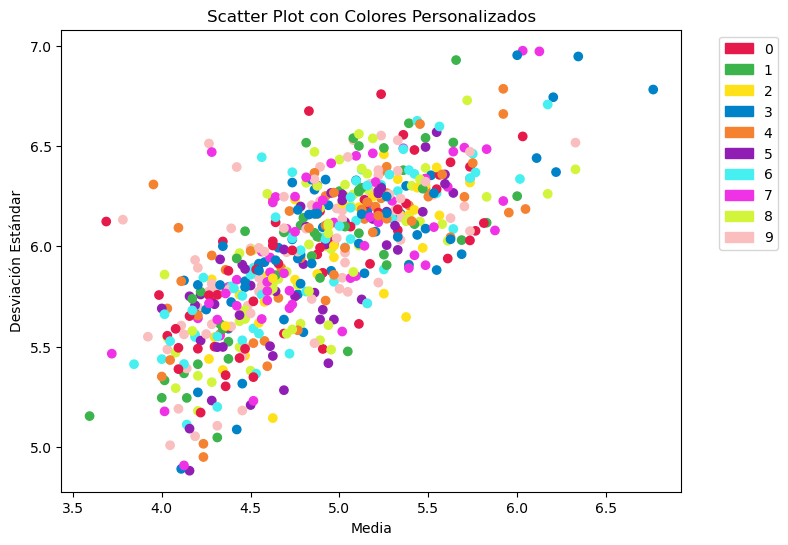

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionario de colores distintos en formato RGB
colores_distintos = {
    0: (230, 25, 75),      # Rojo
    1: (60, 180, 75),      # Verde
    2: (255, 225, 25),     # Amarillo
    3: (0, 130, 200),      # Azul
    4: (245, 130, 48),     # Naranja
    5: (145, 30, 180),     # Púrpura
    6: (70, 240, 240),     # Cyan
    7: (240, 50, 230),     # Magenta
    8: (210, 245, 60),     # Lima
    9: (250, 190, 190)     # Rosa
}

import matplotlib.patches as mpatches

# Crear una leyenda para cada color
patches = [mpatches.Patch(color=np.array(color)/255, label=label) for label, color in colores_distintos.items()]

colores_normalizados = [(r / 255, g / 255, b / 255, 1.0) for (r, g, b) in colores_distintos.values()]

# Supongamos que y_bin_test contiene índices correspondientes a los colores en colores_normalizados
y_bin_test = np.random.randint(0, len(colores_normalizados), size=X_test_features.shape[0])  # Ejemplo: generación aleatoria de índices

# Obtener colores correspondientes a los valores de y_bin_test
colores = [colores_normalizados[y] for y in y_bin_test]

# Graficar scatter plot con los colores personalizados
plt.figure(figsize=(8, 6))
plt.scatter(X_test_features[:, 0], X_test_features[:, 1], c=colores)
plt.xlabel('Media')
plt.ylabel('Desviación Estándar')
plt.title('Scatter Plot con Colores Personalizados')

# Añadir la leyenda al gráfico
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Entregable:
* Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos? 

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



# Respuesta:



La estrategia que mejor funciono fue la de usar las features de mean y standard deviation, pues fue claramente la de mejor accuracy de las dos estrategias propuestas.

Como vimos arriba si graficamos las features media con respecto a desvio estandar, esta nos permite separar mediante una linea recta los 0s de los 1s, y este es el poder de separacion del espacio que tiene nuestro modelo, una solo neurona. Sim embargo si graficamos las features de mean top y mean down vemos que no tienen la capacidad de separar adecuadamente los 0s de los 1s con tan solo una recta, por lo que nuestro modelo no es capaz de realizar una correcta division del espacio.

Si los datos estan balanceados cada instancia de nuestro dataset tiene 50% de chances de ser clasificada correctamente, por lo que nuestra accuracy seria 50%. Para el caso de un problema de clasificacion multiclase cada instancia tiene un 10% de ser clasificada correctamente por lo que nuestra accuracy seria del 10%. 

En el caso de la clasificacion binaria ambas estrategias fueron superiroes a realizar una clasificacion aleatoria, para el caso en el que utilizamos promedio y desvio estandar nos dio un 83% de accuracy mientras que para el caso de promedio superior y promedio inferior nos dio tan solo 54% de accuracy, aunque por muy poca diferencia. 
Para el caso de la clasificacion multiclase tuvimos una accuracy el 14% aunque tampoco logramos una mejora significativa respecto a la prediccion aleatoria, logramos igualmente una mejor accuracy.
